In [ ]:
#| default_exp ECMs

# Imports

In [ ]:
#| export
import projective_simulation.methods.transforms as transforms
import numpy as np

from abc import ABC, abstractmethod

# Abstract ECM

In [ ]:
#| export
class Abstract_ECM(ABC):
    """A minimal ECM, every agent should be Derived from this class. Primarily serves to enforce that all ECMs have the "ECM" class

    Examples:
    >>> pass
    """

    def __init__(self, num_actions: int):
        """
        Args:
            ECM: The ECM Object to use
            percept_processor: An optional object for transforming observations prior to passing to ECM as a percept. Must have method "preprocess"
            action_processor: An optional object for transforming actions prior to passing to Environment as an actuator state. Must have method "postprocess"            
        """

    @abstractmethod
    def deliberate(self, percept: str):
        """
        Args:
            percept: A string corresponding to an existing or new (will be added) key in the ECM percept dictionary
        """
        raise NotImplementedError

# Two Layer ECMs

## Basic Two Layer

In [ ]:
#| export

class Two_Layer(Abstract_ECM):
    def __init__(self, 
                 num_actions: int, # The number of available actions.
                 glow: float, # The glow (or eta) parameter. 
                 damp: float, # The damping (or gamma) parameter. 
                 softmax: float # The softmax (or beta) parameter.
                ):        
        """
        Simple, 2-layered ECM. We initialize an h-matrix with a single row of `num_actions` 
        entries corresponding to a dummy percept clip being connected to all possible actions with h-values of all 1. We 
        initialize a g-matrix with a single row of `num_actions` entries with all 0s corresponding to the *glow* values 
        of percept-action transitions.

        Percepts must be created from new observations with a preprocessor, e.g. add_percepts
                      
        NOTE: This simple version misses some features such as clip deletion, emotion tags or generalization mechanisms.
        
        """
        self.num_actions = num_actions
        self.glow = glow
        self.damp = damp
        self.softmax = softmax
        #int: current number of percepts.
        self.num_percepts = 0
        #np.ndarray: h-matrix with current h-values. Defaults to all 1.
        self.hmatrix = np.ones([1,self.num_actions])
        #np.ndarray: g-matrix with current glow values. Defaults to all 0.
        self.gmatrix = np.zeros([1,self.num_actions])
        #dict: Dictionary of percepts as {"percept": index}
        self.percepts = {}

    def deliberate(self, percept: str):
        """
        Given a percept, returns an action and changes the ECM if necessary
        First, if the percept is new, it will be added to the ECM
        Then, an action is selected as a function of the percept and the h-values of edges connected to that percept
        Finally, the g-matrix is updated based on the realized percept-action pair.
        """
        #Add percept to ECM if not already present
        self.add_percept(percept)
        #Perform Random Walk
        # get index from dictionary entry
        percept_index = self.percepts[percept]
        # get h-values
        h_values = self.hmatrix[percept_index]
        # get probabilities from h-values through a softmax function
        prob = transforms._softmax(self.softmax, h_values)
        # get action
        action = np.random.choice(range(self.num_actions), p=prob)        
        #pdate g-matrix
        self.gmatrix[int(percept_index),int(action)] = 1.
        return action

    def add_percept(self, percept):
        '''
        Checks if percept is in dictionary and adds to ECM in not
        '''
        if percept not in self.percepts.keys(): 
            self.percepts[percept] = self.num_percepts
            # increment number of percepts
            self.num_percepts += 1
            # add column to h-matrix
            self.hmatrix = np.append(self.hmatrix, 
                                     np.ones([1,self.num_actions]),
                                     axis=0)
            # add column to g-matrix
            self.gmatrix = np.append(self.gmatrix, 
                                    np.zeros([1,self.num_actions]),
                                    axis=0)

    def learn(self, reward):
        """
        Given a reward, updates h-matrix. Updates g-matrix with glow.
        """
        # damping h-matrix
        self.hmatrix = self.hmatrix - self.damp*(self.hmatrix-1.)
        # update h-matrix
        self.hmatrix += reward*self.gmatrix
        # update g-matrix
        self.gmatrix = (1-self.glow)*self.gmatrix

## Priming Two Layer

In [ ]:
#| export

class Priming_ECM(Two_Layer):
    '''
    This sub-class of the Two-Layer ECM adds a variable for action priming.
    This variable should be a list of floats, each element of which corresponds to an action in the ECM.
    These "priming values" are summed with h-values of any edge connected to the associated action node prior to calculating walk probabilites with the softmax function
    '''
    def __init__(self, 
                 num_actions: int, # The number of available actions.                 
                 glow: float = 0.1, # The glow (or eta) parameter. 
                 damp: float = 0.01, # The damping (or gamma) parameter. 
                 softmax: float = 0.5, # The softmax (or beta) parameter.
                 action_primes: list = None, #weights on the probability that deliberation steps into each action. Defaults to 0 for each action 
                ):
        if action_primes is None:
            action_primes = [0.] * num_actions
        assert len(action_primes) == num_actions
        super().__init__(num_actions, glow, damp, softmax)
        self.action_primes = action_primes
        

    def deliberate(self, percept):
        '''
        Almost identical to the deliberate function of Two-Layer parent class, but sums h-values and action primes prior to calculating walk probabilities
        '''
        self.add_percept(percept)
        #Perform Random Walk
        # get index from dictionary entry
        percept_index = self.percepts[percept]
        # get h-values
        h_values = self.hmatrix[percept_index]
        #~~~Differences from two-layer deliberate function within
        assert len(h_values) == len (self.action_primes)
        # get probabilities from h-values and primes through a softmax function
        prob = transforms._softmax(self.softmax, h_values + self.action_primes)
        #~~~~~~~
        # get action
        action = np.random.choice(range(self.num_actions), p=prob)        
        #pdate g-matrix
        self.gmatrix[int(percept_index),int(action)] = 1.
        return action

#### Example

[<matplotlib.lines.Line2D>]

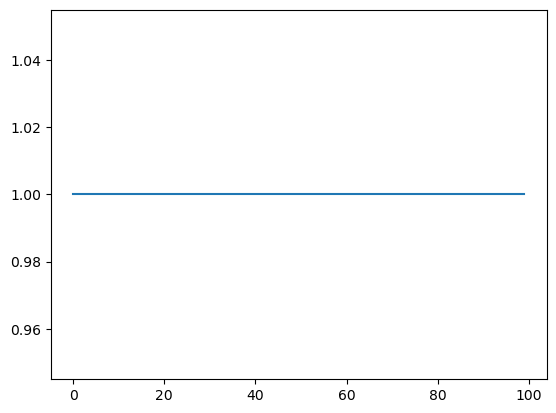

In [ ]:
#|eval : false
from projective_simulation.environments import RLGL
from projective_simulation.ECMs import Priming_ECM

import matplotlib.pyplot as plt

test_ECM = Priming_ECM(num_actions = 2, action_primes = [0., 1.5])
#Number of steps to run simulation
T = 100
data_log = [None] * T
env = RLGL() #create a default red-light-green-light environment

for t in range(T):
    observation = env.get_observation()
    action = test_ECM.deliberate(observation)
    reward = env.get_reward(action)
    test_ECM.learn(reward)
    data_log[t] = {"env_state": env.state, "action": action, "reward": reward}
    env.transition(action)

plt.plot(range(T), [np.mean([data_log[step]["reward"] for step in range(i-10,i+1) if step >= 0]) for i in range(T)]) #plot a 10 step moving average of the reward 

## Episodic ECM

In [ ]:
#| export

class Episodic_Memory(Abstract_ECM):
    def __init__(self,
                 num_actions: int, # the number of perceptual representations available to the agent which, when excited, have an effect on the agent's environment. Action representations are primed differently than sensory representations and do not affect surprise
                 capacity: int = 10, # the number of memory traces avaiable to the agent. If simulation time exceeds capacity, the oldest memory trace will be overwritten each time step
                 softmax: float = 1, # used to determine random walk probabilities, edge weights are normalized using a softmax function with this variable as the temperature constant
                 focus: float = 0., #Focus scales the effect of stochastic processes underlying random walks on the ECM. (i.e. it scales the effect of Projective Simulation)
                                    #Think of deliberation in an Episodic ECM like a very large number of particles diffusing on the ECM graph, but at each node a single particle is chosen at random and some proportion of particles are pulled along with that one. Focus defines that proportion
                                    #If focus == 1, deliberation acts as a random walk of a single (massive) particle on the ECM. 
                                    #If focus == 0, deliberation acts as the diffusion of a large (approaching infinite) number of particles on the ECM
                 kappa: float = 1., #How strongly the agent discounts the similarity between two states per bit of mismatched sensory information when establishing a new belief state
                 intrinsic_expectations: dict = None, #If a key in this dictionary corresponds to an index of the agent's perceptual representations, the items value will be added to that percepts expectation value during the agent's predictions. Agents will seek out states that excite perceptual representations with intrinsic expectation
                 epsilon: float = 0.01,  # a baseline value for the priming of perceptual representations. Must be greater than 0 to prevent infinite surprise if a perceptual representation is excited that was not predicted by the agents belief state. Note this will be transormed by the logistic function, so entropy calculations are not done using precisely this number
                 deliberation_length: int = 1,   # deliberation_length: the number of diffusive steps in the agent's deliberations
                 t: int = 0, #used to model the temporal excitation sequence of memory traces
                 expectation_scale: float = 3 #A logistic function is used to scale percept priming between zero and one. This default rate parameter keeps the function used approximately linear when the input is between 0.1 and 0.8
                ):
        '''
        The episodic memory ECM stores percept information in a time ordered system of memory traces by establishing connections (trace_encoder) with weights (hmatrix) between excited perceptual representations and an excited memory trace.
        The agent maintains a belief state through the activation (different from excitation) of memory traces, where the strength of activation reflects the strength of the agent's belief that its current state-in-the-world is effectively the same as a state-in-the-world represented by that memory trace
        The agent also maintains an expectation state by priming perceptual representations as a function of (1) its belief state, (2) connections between memory traces (mmatrix, stricly time-ordered in this implementation), and (3) the h-matrix
        The difference between the agent's expectation state and the excitation of perceptual represenations in the next time step is computed as a surprise and assigned to the last excited memory trace as a valence state
        Perceptual representations are excited as a function of sensory-motor interactions with the world and the agent's expectation state
        Memory Traces are excited in a time-ordered, winner-takes all fashion.
        The agent's beliefs are updated by a process of deliberation, in which excited perceptual representations are activated and those activations then diffuse across the ECM as if they were caused by particles performing a random walk on the ECM graph
        The probability that an activation particle walks from one node to another is a function of the edge weights in the hmatrix connected to its current node (perceptual representation or memory trace), and the belief states and valence states of all nodes to which those edges lead
        The focus parameter of the Episodic ECM adds weight to a single departing edge from each node, adding stochastic bias to the random walk. Rewards reinforce edge weights in the ECM proportionally to the difference between the expected particle mass to traverse that edge and the observed mass
        Rewards are determined as a function of the "surprise advantage", i.e. how much more or less surprised the agent was then on average over its previous (relevant) experience.
        '''

        #initialize constants
        self.num_actions = num_actions
        self.capacity = capacity
        self.softmax = softmax
        self.focus = focus 
        self.kappa = kappa
        self.intrinsic_expectations = {} if intrinsic_expectations is None else intrinsic_expectations
        self.epsilon = epsilon
        self.deliberation_length = deliberation_length
        self.surprise: float = None
        self.expectation_scale = expectation_scale
        
        #initialize modelling variables
        self.t = t

        #initialize ECM states
        self.hmatrix = np.zeros((self.num_actions, self.capacity)) #weights connecting percept nodes to trace nodes
        self.mmatrix = np.zeros((self.capacity, self.capacity)) #initialize with no connections between memory traces
        self.trace_encoder = np.zeros((self.num_actions, self.capacity), dtype = 'bool') #boolean matrix indicating whether a percept node was encoded in a trace
        self.action_encoder = np.ones(self.num_actions, dtype = 'bool') #boolean matrix indicated whether a percept node belongs to an action
        self.expectations = np.zeros(self.num_actions)
        self.beliefs = np.zeros(self.capacity) #initilize with no belief weight on any memory traces
        self.valences = np.array([np.nan] * self.capacity) #use nan here because we will want to takes means of this array as it is filled
        self.percept_activations = np.zeros(np.shape(self.hmatrix)[0]) #initialize with no activation of percept nodes
        self.trace_activations = np.zeros(self.capacity) #initialize with no activation of memory traces
        self.trace_excitations = np.zeros(self.capacity) #trace excitations represent the sensory evidence that the world is currently in a state that is effectively represented by the excited trace
        

    def deliberate(self, percept):
        self.add_percept(percept)
        self.surprise = self.get_surprise(percept)
        self.excite_traces(percept)
        self.encode_trace(percept)
        self.activate()
        for deliberation_step in range(self.deliberation_length):
            self.diffuse_activation()
        self.predict()
        self.t = (self.t + 1) % self.capacity
        return(self.expectations[self.action_encoder]) #return action priming

    def add_percept(self, percept):
        if len(percept) > np.shape(self.hmatrix)[0]: #if percept is longer than the first dimension of the hmatrix it means there is something new in the observation (handled by preprocessor)
            i = np.shape(self.hmatrix)[0] #get index for new elements in ECM
            new_elements = percept[i:len(percept)]    
            self.hmatrix = np.append(self.hmatrix, np.zeros((len(new_elements), self.capacity)), axis = 0) #add baseline weights to connections between new percept nodes and all traces
            self.trace_encoder = np.append(self.trace_encoder, np.zeros((len(new_elements), self.capacity), dtype = 'bool'), axis = 0) #new percept nodes have no existing connections to trace nodes
            self.action_encoder = np.append(self.action_encoder, np.zeros(len(new_elements), dtype = 'bool')) #this ECM does not support new actions, so new percept nodes are sensory by default
            self.expectations = np.append(self.expectations, np.array([transforms._shifted_exp(0,0, epsilon = self.epsilon) for x in range(len(new_elements))])) #sets new expectation states the same as existing sensory representations not predicted by deliberation
            
    def excite_traces(self, percept):
        self.trace_excitations = np.zeros(self.capacity)
        # each trace is excited proportionally to the probability that of the n connections it has to perceptual representations, each of those perceptual representations are excited . . .
        # . . . if that trace effectively represents the current world state . . .
        # . . . a logistic transfomation of connecting edge gives the probability that a sensory representation fails to excite when the world is in the state represented by the memory trace.
        for t_index in range(self.capacity):
            connections = [i for i in range(np.shape(self.trace_encoder)[0]) if self.trace_encoder[i,t_index]] #indexes of percept nodes with connections to memory trace
            if np.sum(connections) > 0: #no excitation if trace has no connections (functionally this shouldn't matter, but it is nicer for interpretation)
                #we fill the likelihoods vector
                excitation_probs = transforms._logistic(self.hmatrix[connections,t_index], k = self.kappa)
                likelihoods = excitation_probs**percept[connections] * ((1-excitation_probs)**(1-percept[connections])) #probabilities of Bernoulli trials with outcome equal to the excitation of connected percept nodes
                self.trace_excitations[t_index] = np.prod(likelihoods)
    
    def encode_trace(self, percept):
        self.trace_encoder[0:,self.t] = [x > 0 for x in percept] #connect all excited percepts to current trace
        self.hmatrix[0:,self.t] = percept #h-values of edges are set to excitation of connected representation
        self.mmatrix[self.t-1,self.t] = 1 #create forward connection from previous trace to current trace (this is a spurious but inconsequential connection for an agent's first step)
        self.mmatrix[self.t,0:] = [0 for x in self.mmatrix[self.t,0:]] #break any forward connections from current trace (only relevant if t is greater than self.capacity)
        self.valences[self.t-1] = self.surprise #valence is assigned to the last trace, it relfects how surprised the agent was by the outcome of the action it took in that trace
    
    def activate(self):
        activation_weights = transforms._softmax(self.softmax, self.hmatrix[self.trace_encoder[0:,self.t],self.t]) #softmax function over edge weights connected to current memory trace
        random_selection = np.random.choice(range(len(activation_weights)), p = activation_weights) #get destination of PS random walk
        self.percept_activations = np.zeros(np.shape(self.hmatrix)[0]) #reset activations
        #bias activation toward starting node of PS random walk
        self.percept_activations[self.trace_encoder[0:,self.t]] = [activation_weights[i] + self.focus*(1-activation_weights[i]) if i == random_selection else activation_weights[i] * (1-self.focus) for i in range(len(activation_weights))]

    def diffuse_activation(self):
        new_percept_activations = np.zeros(np.shape(self.hmatrix)[0])
        new_trace_activations = np.zeros(self.capacity)
        #get diffusion from percept nodes
        for i in range(np.shape(self.hmatrix)[0]):
            #edge weights are the product of the the edge h-values exponent (relevance), the prior expectation of the trace to which the edge is connected (belief prior), and the excitation of the trace to which the edge is connected (sensory evidence)
            edge_weights = self.hmatrix[i,self.trace_encoder[i,0:]] * self.beliefs[self.trace_encoder[i,0:]] * self.trace_excitations[self.trace_encoder[i,0:]]
            if len(edge_weights) > 0: #dont diffusion activation if there are no edges (there should not be to activation to diffuse)
                edge_probs = transforms._softmax(self.softmax, edge_weights)
                random_selection = np.random.choice(range(len(edge_weights)), p = edge_probs) #get destination of Projective Simulations
                diffusion_mass = _get_diffusion_mass(self.percept_activations[i], edge_probs, random_selection, self.focus)
                new_trace_activations[self.trace_encoder[i,0:]] = new_trace_activations[self.trace_encoder[i,0:]] + diffusion_mass
        #get diffusion from memory traces
        for n in range(np.shape(self.hmatrix)[1]):
            #edge weights are the product of the the edge h-values exponent (relevance), the activation of the trace to which the edge is connected (belief prior), and the excitation of the trace to which the edge is connected (sensory evidence)
            edge_weights = np.exp(self.hmatrix[self.trace_encoder[0:,n],n])
            if len(edge_weights) > 0: #dont diffuse activation if there are no edges (there should not be to activation to diffuse)    
                edge_probs = transforms._softmax(self.softmax, edge_weights)
                random_selection = np.random.choice(range(len(edge_weights)), p = edge_probs) #get destination of Projective Simulations
                diffusion_mass = _get_diffusion_mass(self.trace_activations[n], edge_probs, random_selection, self.focus)
                new_percept_activations[self.trace_encoder[0:,n]] = new_percept_activations[self.trace_encoder[0:,n]] + diffusion_mass
        self.percept_activations = new_percept_activations
        self.trace_activations = new_trace_activations

    def predict(self):
        self.beliefs = np.matmul(self.trace_activations, self.mmatrix) # because each row of the matrix has either zeros or a single 1, this just propogates attention forward. non-linear functions might be necessary for more complex mmatrix structures
        self.expectations = np.zeros(np.shape(self.hmatrix)[0]) #hmatrix rows correspond to perceptual representations
        for trace in range(self.capacity):
            priming_scalers =  np.log(np.nanmean(self.valences)/self.valences)  #used to scale priming of action representations as a function of trace valence
            priming_scalers[np.isnan(priming_scalers)] = 0 #traces without valence do not prime (including current trace)
            #add to the expectation weight of each percept node the expectation weight of the given trace times the weight of its connection to that percept node times the priming scaler (set to one if the given percept nodes is a sensory representation)
            self.expectations = self.expectations + self.beliefs[trace] * transforms._logistic(self.hmatrix[0:,trace], k = self.kappa) * self.trace_encoder[0:,trace] * priming_scalers[trace] ** self.action_encoder # final term sets priming to scale to 1 if the percept node is a sensory representation
        intrinsics = np.array([intrinsic_expectations.values()[i] if i in self.intrinsic_expectations.keys() else 0 for i in range(np.shape(self.hmatrix)[0])]) #not sure whether this is nice/faster than maintaining a vector of intrinsic expectations that has zeros added whenever a new sensory representation is created?
        self.expectations = np.array([transforms._shifted_exp(x = self.expectations[i], k = intrinsics[i], epsilon = self.epsilon) for i in range(len(self.expectations))]) # right now this has the property of slightly changing action priming. Could easily just exclude action representations from this operation, but maybe there is a more elegant solution?
        
    def get_surprise(self, percept):
        not_action = np.invert(self.action_encoder) #used to exclude action representations from surprise computations
        return np.sum(np.where(percept[not_action], -np.log2(self.expectations[not_action]), -np.log2(1-self.expectations[not_action])))
            
def _get_diffusion_mass(activation, edge_probs, random_selection, focus):
    #gets the activation mass that diffuses along each edge connected to a perceptual representation. Note the different effect of the focus parameter if the edge was selected by PS random walk
    diffusions = [None] * len(edge_probs)
    for i in range(len(edge_probs)):
        if i == random_selection:
            diffusions[i] = activation * (edge_probs[i] + focus*(1-edge_probs[i]))
        else:
            diffusions[i] = activation * edge_probs[i] * (1 - focus)
    return(diffusions)  

## Bayesian Memory Network

The Bayesian Memory Network encodes sequences of input states (binary percept encodings) into an "episodic-like" memory by setting "excitation weights" that connect representations of perceptual elements to memory traces. Memory traces are then connected to each other by Hebbian Weights and Clip Weights. The propogation of information through the resulting graph results in predictions regarding the next percept the Bayesian Memory Network will recieve.

This propogation of information can be broadly understood in three steps. 

First, memory trace are excited as a function of the excitation state of each element (representation) of the percept (0 or 1) and the weights of the excitation edges connecting that trace to the respective perceptual representation. Excitation weights can be understood as the probability with which the agent believes the connected percept representation will be excited, given that the connected memory trace effectively represents the agent's situation within a larger environment. Computationally, then, the excitation state of the agent's memory trace gives the likelihood of the current percept given the agent's beliefs about the situated state which that trace effectively represents.

Second, a single memory trace is activated: its activation state is set to one, its other states are set to baseline, and its associated excitation weights are set according to the current percept - thus encoding the memory. This activation is then allowed to diffuse along the Hebbian Edges that connect that trace to all others, as a function of: those weights of the Hebbian edges the trace is connected to, the excitation of memory traces to which those edges lead, and the agent's prior expectation that the trace to which the edge leads will effectively represent it's current situation in the world (more on this last state in a moment). So long as the Hebbian Edge weights are all 1, activation becomes distributed amongst traces proportionally to the product of each trace's excitation state and expectation state. Thus, this process is computationally equivalent to a Bayesian update in which the set of memory traces in the BMN are assumed to respresent the true set of states from which percepts are generated and the activation state of any trace following diffusion on the graph represents the probability with the agent believes that its current situation in the world is well represented by that trace.

Thirdly and finally, an expectation state is set on traces by passing the activation state along Clip Edges. Clip Edge weights are set such that activation of a memory trace will most strongly increase the expectation of the memory trace that was encoded directly after it. Thus, the expectation state of a memory trace can be understood as the probability with which the agent believes that that trace will effectively represent its upcoming situation in the broader environment. Expectation is then further passed to the perceptual representations as a function of the excitation weights connecting expected traces to the perceptual representation. Recalling that the excitation weights give the probability with which the agent believes a perceptual representation will be excited given that the agent's situation within an environment is well represented by a particular memory trace, the expectation state of a perceptual representation is computed such that it gives the probability with which the agent believes that representation will be excited by its upcoming situation in the environment, given the agent's beliefs about how probable it is that each memory trace will effectively represent that upcoming situation.

In [ ]:
#| export

class Bayesian_Memory_Network(Abstract_ECM):
    def __init__(self,
                 N_traces: int = 100,
                 kappa: float = 3., #How strongly the agent discounts the similarity between two states per bit of mismatched sensory information when establishing a new belief state
                 epsilon: float = 0.01,  # a baseline value for the priming of perceptual representations. Must be greater than 0 to prevent infinite surprise if a perceptual representation is excited that was not predicted by the agents belief state. Note this will be transormed by the logistic function, so entropy calculations are not done using precisely this number
                 gnosticism: float = 1, #The higher this value, the more strongly the ECMs attention will move toward encoded memory traces relative to unencoded memory traces, thus its predictions will be more strongly influenced by its past experiences
                 intrinsic_expectations: np.array = None, #each element of this 1d array scales the expectation state for a corresponding perceptual representation. Positiove values push this state toward 1, negative values toward 0.
                 simulation_determinism: float = 5, #used as a softmax temperature when passing attention weights along clip matrix. When high, more attention from a given trace is passed as expectation to the trace(s) with the highest connection in the clip matrix
                 t: int = 0
                ):
        '''
        The Bayesian Memory Network is a graph that acts like a recurrent neural network to perform an approximate Bayesian Inference in unknown environments (where the true posterior is not known).
        It takes a binary string (its percept) as input, and returns the probablity that each element of the next percept it recieves will be 1. Predictions are made based on the last N_traces percepts observed.
        '''
        super().__init__(num_actions = 0)
        #initialize constants
        self.N_traces = N_traces
        self.kappa = kappa
        self.epsilon = epsilon
        self.gnosticism = gnosticism
        self.intrinsic_expectations = np.array([]) if intrinsic_expectations is None else intrinsic_expectations
        self.simulation_determinism = simulation_determinism
        
        #initialize modelling variables
        self.t = t
        self.surprise: float = None

        #initialize ECM states
        self.W = np.full(shape = (len(self.intrinsic_expectations), self.N_traces), fill_value = -self.gnosticism) #weights connecting percept nodes to trace nodes. The higher the ECMs gnosticim parameter, the more excited sesory representations will inhibit the excitation of unencoded memory traces
        self.H = np.zeros((self.N_traces, self.N_traces)) #initialize with equal associative weights between memory traces
        self.C = np.zeros((self.N_traces, self.N_traces)) #initialize with equal clip weights between memory traces
        self.percept_excitations = np.zeros(np.shape(self.intrinsic_expectations)[0])
        self.percept_expectations = np.array([]) if intrinsic_expectations is None else np.vectorize(transforms._shifted_exp)(0, self.intrinsic_expectations, self.epsilon) #sets initial percept expectations based on intrisic expectations and zero attention to associated memory traces
        self.trace_excitations = np.zeros(self.N_traces)
        if not np.shape(self.percept_excitations)[0] == 0:
            self.excite_traces()
        self.trace_expectations = np.full(shape = N_traces, fill_value = 1/self.N_traces) #trace excitations represent the sensory evidence that the world is currently in a state that is effectively represented by the excited trace
        self.trace_activations = np.zeros(self.N_traces) #initialize with no activation of memory traces
        
    def deliberate(self, percept):
        '''
        iterates over each of the ECMs operations after recieving a new state (percept)
        '''
        self.percept_excitations = percept
        self.add_percept()
        self.excite_traces()
        self.encode_trace()
        self.activate()
        self.diffuse_activation()
        self.predict()
        self.t = (self.t + 1) % self.N_traces
        return [] #return action priming

    def add_percept(self):
        '''
        Checks whether current excitation state contains new percept representations and adds any such representations to the BMNs W matrix and percept_excitations vector
        '''
        if np.shape(self.percept_excitations)[0] > np.shape(self.W)[0]: #if percept excitation is longer than the first dimension of the excitations weights it means there is something new in the percept
            i = np.shape(self.W)[0] #get index for new elements in ECM
            new_elements = self.percept_excitations[i:]    
            self.W = np.append(self.W, np.full(shape = (len(new_elements), self.N_traces), fill_value = -self.gnosticism), axis = 0) #add baseline inhibitory weights (-1) to connections between new percept nodes and all traces
            self.percept_expectations = np.append(self.percept_expectations, np.array([transforms._shifted_exp(0,0, epsilon = self.epsilon) for _ in range(len(new_elements))])) #sets new expectation states the same as existing sensory representations not predicted by deliberation
            self.intrinsic_expectations = np.append(self.intrinsic_expectations, np.zeros(len(new_elements)))
                                                    
    def excite_traces(self):
        '''
        Excites the memory traces as a function of percept representation excitation, excitation weights, and the kappa parameter.
        '''
        percept_excitation_likelihoods = np.vectorize(transforms._logistic)(x = self.W, k = self.kappa)
        self.trace_excitations = np.array([np.prod(percept_excitation_likelihoods[0:,j] ** self.percept_excitations * (1 - percept_excitation_likelihoods[0:,j]) ** (1 - self.percept_excitations)) for j in range(self.N_traces)])
    
    def encode_trace(self):
        '''
        update W and C as function of new percept and internal phase tracker (t)
        '''
        self.W[0:,self.t] = [1 if self.percept_excitations[i] == 1 else -1 for i in range(np.shape(self.W)[0])] #excitation weights to new trace are set to baseline activation (1) or inhibition (-1) based on current percept excitations
        self.C[self.t-1,self.t] = 1 #create forward connection from previous trace to current trace (this is a spurious but inconsequential connection for an agent's first step)
        self.C[self.t,0:] = [0] * np.shape(self.C)[1] #break any forward connections from current trace (only relevant if T is greater than N_traces)
        
    
    def activate(self):
        '''
        removes excitation and expectation from newly encoded trace, sets its activation to 1, and removes activation from all other traces
        '''
        self.trace_excitations[self.t] = 0
        self.trace_expectations[self.t] = 0
        self.trace_activations = np.array([1 if i == self.t else 0 for i in range(self.N_traces)])

    def diffuse_activation(self):
        '''
        Allows activation to diffusion along H matrix
        '''
        projection_weights = np.exp(self.H) * self.trace_expectations * self.trace_excitations
        projection_probabilities = projection_weights * (1/(projection_weights @ np.ones((np.shape(projection_weights)[1],1)))) #divides each transition weight by the sum of transition weights in its row
        self.trace_activations = self.trace_activations @ projection_probabilities

    def predict(self):
        '''
        sets new expectation states
        '''
        simulation_weights = np.exp(self.simulation_determinism * self.C)
        simulation_probabilities = simulation_weights * (1/(simulation_weights @ np.ones((np.shape(simulation_weights)[1],1)))) #divides each transition weight by the sum of transition weights in its row
        self.trace_expectations = self.trace_activations @ simulation_probabilities
        conditional_percept_probabilities = np.vectorize(transforms._logistic)(self.W, k = self.kappa)
        self.percept_expectations = conditional_percept_probabilities @ self.trace_expectations
        self.percept_expectations = np.vectorize(transforms._shifted_exp)(x = self.percept_expectations, k = self.intrinsic_expectations, epsilon = self.epsilon)

    def get_surprise(self):
        return np.sum(np.where(self.percept_excitations[self.num_actions:], -np.log2(self.percept_expectations[self.num_actions:]), -np.log2(1-self.percept_expectations[self.num_actions:]))) #sum for each percept representation log expecataion if excited, 1 - log expectatin if not excited
        


### Example

In this minimal example, we create a Bayesian Memory Network with ten available traces. Over fifteen time steps, we alternate whether or not a single perceptual representation is excited, and observe the BMN learning to predict this pattern. Note than after ten time steps, learning stops: the agent can only remember the last ten percepts from which it draws information to make predictions

In [ ]:
BMN = Bayesian_Memory_Network(N_traces = 10)
for t in range(15):
    BMN.deliberate(np.array([t % 2]))
    print("percept expectation at time " + str(t) + ": " + str(np.round(BMN.percept_expectations, decimals = 3)))

percept expectation at time 0: [0.057]
percept expectation at time 1: [0.299]
percept expectation at time 2: [0.319]
percept expectation at time 3: [0.109]
percept expectation at time 4: [0.863]
percept expectation at time 5: [0.077]
percept expectation at time 6: [0.899]
percept expectation at time 7: [0.081]
percept expectation at time 8: [0.912]
percept expectation at time 9: [0.087]
percept expectation at time 10: [0.923]
percept expectation at time 11: [0.087]
percept expectation at time 12: [0.923]
percept expectation at time 13: [0.087]
percept expectation at time 14: [0.923]


## Active Inference Memory Network

The Active Inference Memory Network builds upon the Bayesian Memory Network by allowing a set of perceptual represenations to correspond to actions and by modulating the expectation state of those action representations as a function of a "surprise" value which is now encoded in memory traces.

In [ ]:
#|export

class Active_Inference_Memory_Network(Bayesian_Memory_Network):
    def __init__(self,
                 num_actions: int,
                 N_traces: int = 100,
                 kappa: float = 3., #How strongly the agent discounts the similarity between two states per bit of mismatched sensory information when establishing a new belief state
                 epsilon: float = 0.01,  # a baseline value for the priming of perceptual representations. Must be greater than 0 to prevent infinite surprise if a perceptual representation is excited that was not predicted by the agents belief state. Note this will be transormed by the logistic function, so entropy calculations are not done using precisely this number
                 gnosticism: float = 1, #The higher this value, the more strongly the ECMs attention will move toward encoded memory traces relative to unencoded memory traces, thus its predictions will be more strongly influenced by its past experiences
                 intrinsic_sensory_expectations: np.array = None, #each element of this 1d array scales the expectation state for a corresponding SENSORY representation (SHOULD NOT INCLUDE ACTION REPRESENTATIONS). Upon initiation, AIMN constructs an intrinsic_expectations variable from this array and num_actions
                 simulation_determinism: float = 5, #used as a softmax temperature when passing attention weights along clip matrix. When high, more attention from a given trace is passed as expectation to the trace(s) with the highest connection in the clip matrix
                 t: int = 0,
                 memory_valences: float = None
                ):
        self.num_actions = num_actions
        self.memory_valences = np.array([np.nan] * N_traces) if memory_valences is None else memory_valences
        if intrinsic_sensory_expectations is None:
            intrinsic_expectations = np.zeros(num_actions)
        else:
            intrinsic_expectations = np.append(np.zeros(num_actions), intrinsic_sensory_expectations)
        
        super().__init__(N_traces = N_traces, kappa = kappa, epsilon = epsilon, gnosticism = gnosticism, 
                         intrinsic_expectations = intrinsic_expectations, simulation_determinism = simulation_determinism, t = t)

    

    def encode_trace(self):
        super().encode_trace()
        self.memory_valences[self.t - 1] = self.get_surprise()

    def predict(self):
        '''
        sets new expectation states
        '''
        #first four line the same as Bayesian Memory Network~~~~~
        simulation_weights = np.exp(self.simulation_determinism * self.C)
        simulation_probabilities = simulation_weights * (1/(simulation_weights @ np.ones((np.shape(simulation_weights)[1],1)))) #divides each transition weight by the sum of transition weights in its row
        self.trace_expectations = self.trace_activations @ simulation_probabilities
        conditional_percept_probabilities = np.vectorize(transforms._logistic)(self.W, k = self.kappa)
        #~~~~~~
        #Modify predictions to 'prime' action representations
        priming = np.log(np.nanmean(self.memory_valences)/self.memory_valences)  #used to scale priming of action representations as a function of trace valence
        priming[np.isnan(priming)] = 0 #traces without valence do not prime (including current trace)
        for i in range(self.num_actions):
            conditional_percept_probabilities[i,0:] = conditional_percept_probabilities[i,0:] * priming
        self.percept_expectations = conditional_percept_probabilities @ self.trace_expectations
        #adjust expectation based on intrinsic expectations
        self.percept_expectations = np.vectorize(transforms._shifted_exp)(x = self.percept_expectations, k = self.intrinsic_expectations, epsilon = self.epsilon)
        
                           

In [ ]:
test_AIM = Active_Inference_Memory_Network(num_actions = 2, intrinsic_sensory_expectations = np.array([0,2]))
test_AIM.deliberate(np.array([1,0,1,0]))
test_AIM.deliberate(np.array([1,0,0,0]))
test_AIM.deliberate(np.array([1,0,1,0]))
test_AIM.deliberate(np.array([1,0,0,0]))
test_AIM.deliberate(np.array([0,1,1,0]))
test_AIM.deliberate(np.array([0,1,0,1]))
test_AIM.deliberate(np.array([0,1,1,1]))
test_AIM.deliberate(np.array([0,1,0,1]))
print(test_AIM.percept_expectations)
test_AIM.deliberate(np.array([1,0,1,1]))
print(test_AIM.percept_expectations)
test_AIM.deliberate(np.array([1,0,0,0]))
print(test_AIM.percept_expectations)
test_AIM.deliberate(np.array([1,0,1,0]))
print(test_AIM.percept_expectations)
test_AIM.deliberate(np.array([0,1,0,0]))
print(test_AIM.percept_expectations)
test_AIM.deliberate(np.array([0,1,1,1]))

[0.0590074  0.94519832 0.58810569 0.93326371]
[0.00595979 0.52178372 0.0822386  0.90402525]
[0.14611547 0.38694216 0.54577185 0.70317034]
[0.08655953 0.02921709 0.08034339 0.70134384]
[0.02097371 0.1109066  0.1646673  0.74118359]


array([0.03691235, 0.56865592, 0.11503003, 0.93436008])

In [ ]:
test_AIM.memory_valences       

array([1.74310639, 5.45182924, 1.77754646, 2.43905815, 0.67528552,
       3.78738387, 0.55285169, 0.86549595, 3.50501032, 2.62592292,
       1.86427545,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [ ]:
test_AIM.intrinsic_expectations

array([0., 0., 0., 2.])

In [ ]:
transforms._shifted_exp(0.5, 2, 0.01)

0.9104705378870178